# Fake News Detection Project
### By Ofir Sered and Hadar Asher
June 2023

## General Imports and Setup
###### Separted to Crawling, Machine learning, EDA, Visualisation and Text analysis

In [122]:
# --------
# general imports
# --------
import pandas as pd
import scipy as sc
import numpy as np
import re
import os
import time
# --------
#crawling
# --------
import bs4
from bs4 import BeautifulSoup  
import requests
import selenium
from selenium import webdriver
from selenium.common.exceptions import StaleElementReferenceException
from selenium.common.exceptions import NoSuchElementException
from selenium.common.exceptions import ElementClickInterceptedException
from selenium.webdriver.common.by import By
# --------
#machine learning
# --------
import sklearn 
from sklearn import preprocessing, metrics, naive_bayes, feature_extraction, linear_model
from sklearn.feature_extraction import text
from sklearn.preprocessing import Normalizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn import neighbors, tree, ensemble, svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix,classification_report,r2_score
from sklearn.linear_model import LinearRegression
# --------
#EDA, visualisation and text analysis
# --------
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
from PIL import Image
from wordcloud import WordCloud
import seaborn as sns
import matplotlib as mpl
from matplotlib import pyplot as plt
%matplotlib inline
# --------
webdriver_path=r"C:\Users\hadar\Documents\chromedriver_win32\chromedriver.exe"


### general functions
used for saving data in several points in the code


In [12]:
#load soup object from html site
def load_soup_object(html_file_name):
    page=requests.get(html_file_name)
    soup=BeautifulSoup(page.content,'html.parser')
    return soup

In [13]:
#write list to file. One cell per line (for url's lists)
def write_list_to_file(file_name,list_name):
    with open(file_name, 'a') as f:
        for li in list_name:
            f.write("%s\n" % li)

In [14]:
#read file to list line by line (for url's lists)
def read_list_from_file(file_name):
    with open(file_name,'r') as f:
        lines = [line.strip() for line in f.readlines()]
    return lines

## Crawling section-
### Crawler for each website separate to two functions:
* Url crawler for the main page
* Crawl through the articles and collect data for dataset</br></br>
<b>Crawling websites of:</b>
* Empire News, Info Wars News - Fake news
* Fox News, NBC News - Reliable news
* Associated with misinformation(for prediction) - Israel 365 News, Middle East Monitor

### Start of scrapping Israel 365 News website
scrapping from multiple pages with 'load more' button 

used Stackoverflow for selenium example- https://stackoverflow.com/questions/68792444/how-to-scrape-website-if-it-has-load-more-button-to-load-more-content-on-the-pag

In [41]:
def israel365news_crawler(webdriver_path,max_links):
    driver=webdriver.Chrome(executable_path=webdriver_path)
    soup=load_soup_object('https://www.israel365news.com/israel-news/')

    try:
        driver.maximize_window() #ensures that the window occupies the entire screen.
        driver.implicitly_wait(10) #wait for up to 10 seconds for the element to appear before throwing an exception
        driver.get("https://www.israel365news.com/israel-news/")

        urls=[]

        while max_links>=0:
            if max_links%100==0: print(f'{max_links} urls until finish')
            articles=soup('h1',attrs={"class":"elementor-heading-title elementor-size-default"})

            for art in articles:
                a=art.find('a')
                try:
                    if 'href' in a.attrs:
                        url=a.get('href')
                        urls.append(url)
                        max_links-=1
                except:
                    continue

            loadmore=driver.find_element("xpath", "//a[contains(@class, 'elementor-button-link') and contains(@class, 'elementor-button')]")

            if loadmore.is_displayed():
                driver.execute_script("arguments[0].click();", loadmore)
                time.sleep(5)
            else:
                print("no more articles to load")
                break

    except StaleElementReferenceException:
        pass

    finally:
        driver.quit()
    return urls


In [42]:
urls_list=israel365news_crawler(webdriver_path,10000)


C:\Users\hadar\AppData\Local\Temp\ipykernel_6828\2713619630.py:5: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver=webdriver.Chrome(executable_path=webdriver_path)


10000 urls until finish
9900 urls until finish
9800 urls until finish
9700 urls until finish
9600 urls until finish
9500 urls until finish
9400 urls until finish
9300 urls until finish
9200 urls until finish
9100 urls until finish
9000 urls until finish
8900 urls until finish
8800 urls until finish
8700 urls until finish
8600 urls until finish
8500 urls until finish
8400 urls until finish
8300 urls until finish
8200 urls until finish
8100 urls until finish
8000 urls until finish
7900 urls until finish
7800 urls until finish
7700 urls until finish
7600 urls until finish
7500 urls until finish
7400 urls until finish
7300 urls until finish
7200 urls until finish
7100 urls until finish
7000 urls until finish
6900 urls until finish
6800 urls until finish
6700 urls until finish
6600 urls until finish
6500 urls until finish
6400 urls until finish
6300 urls until finish
6200 urls until finish
6100 urls until finish
6000 urls until finish
5900 urls until finish
5800 urls until finish
5700 urls 

OSError: [Errno 22] Invalid argument: 'https://www.israel365news.com/israel-news/'

In [45]:
write_list_to_file('israel365news_urls.txt',urls_list)

###### Crawl through all articles from Israel365News we've collected


In [111]:
def load_articles_to_df_israel365news(urls_list):
    headline=[]
    writers=[]
    date=[]
    genre=[]
    content=[]
    i=0
    
    for url in urls_list:
        soup=load_soup_object(url)
        headline.append(soup.find("h1",attrs={"class":"elementor-heading-title elementor-size-default"}).get_text().strip())
        writers.append(soup.find("h4",attrs={"class":"elementor-author-box__name"}).get_text().strip())
        date.append(soup.find("div",attrs={"class":"elementor-element elementor-element-8f04d6d elementor-widget__width-auto elementor-widget elementor-widget-heading"}).find("h2").get_text().strip())
        genre.append(", ".join(item.get_text().strip() for item in soup.find("div",attrs={"class":"elementor-element elementor-element-1a40dbf elementor-widget__width-auto text-hover elementor-widget elementor-widget-heading"}).find_all("a")))
        content.append(soup.find("div",attrs={"class":"elementor-element elementor-element-2106a85 elementor-widget elementor-widget-theme-post-content"}).get_text().strip()) 
        i+=1
        if(i%100==0):
            print(f'{i} articles scrapped')

    df=pd.DataFrame({"headline":headline,"writers":writers,"date":date,"genre":genre,"content":content})
    return df

In [112]:
df=load_articles_to_df_israel365news(urls_list)

100 articles scrapped
200 articles scrapped
300 articles scrapped
400 articles scrapped
500 articles scrapped
600 articles scrapped
700 articles scrapped
800 articles scrapped
900 articles scrapped
1000 articles scrapped
1100 articles scrapped
1200 articles scrapped
1300 articles scrapped
1400 articles scrapped
1500 articles scrapped
1600 articles scrapped
1700 articles scrapped
1800 articles scrapped
1900 articles scrapped
2000 articles scrapped
2100 articles scrapped
2200 articles scrapped
2300 articles scrapped
2400 articles scrapped
2500 articles scrapped
2600 articles scrapped
2700 articles scrapped
2800 articles scrapped
2900 articles scrapped
3000 articles scrapped
3100 articles scrapped
3200 articles scrapped
3300 articles scrapped
3400 articles scrapped
3500 articles scrapped
3600 articles scrapped
3700 articles scrapped
3800 articles scrapped
3900 articles scrapped
4000 articles scrapped
4100 articles scrapped
4200 articles scrapped
4300 articles scrapped
4400 articles scrapp

In [3]:
df.to_csv('israel365news.csv', index=False)

In [114]:
df

,headline,writers,date,genre,content
0,Knesset passes 2023-2024 state budget,JNS,"May 24, 2023",Israel News,Israel’s Knesset on Wednesday passed the state...
1,Will flights from Israel to Mecca spark Temple...,Adam Eliyahu Berkowitz,"May 23, 2023",Israel News,Prime Minister Netanyahu was in direct contact...
2,Rabbi Leo Dee weighs $1.3b. suit against Amanpour,JNS,"May 23, 2023",Israel News,Rabbi Leo Dee is considering suing CNN chief i...
3,Israeli Cabinet boosts funds for Kotel infrast...,JNS,"May 22, 2023",Israel News,The Israeli Cabinet on Sunday approved funding...
4,Ben-Gvir visits Temple Mount: ‘We are the owne...,JNS,"May 21, 2023",Israel News,During a visit to the Temple Mount in Jerusale...
...,...,...,...,...,...
10015,Israeli forces kill two terrorists in raid nea...,JNS,"May 10, 2023","Israel News, Judea and Samaria",Israeli forces killed two Palestinian terroris...
10016,IDF eliminates three top Palestinian Islamic J...,JNS,"May 9, 2023","Israel News, Terror Watch",The Israel Defense Forces killed three top Pal...
10017,"After six years, Israel razes illegal PA struc...",JNS,"May 8, 2023",Israel News,Israel’s Civil Administration demolished a Pal...
10018,Jerusalem Day: Mass return to the Temple Mount...,Adam Eliyahu Berkowitz,"May 7, 2023",Israel News,Temple Mount advocacy groups are planning some...


### End of scrapping Israel 365 News website
### ---------------------------------------------------
### Start of scrapping MiddleEast Monitor website

In [169]:
def load_articles_url_MEM(n_pages):
    soup=load_soup_object(r'https://www.middleeastmonitor.com/category/news/middle-east/')
    articles=soup("li")
    urls=[]
    
    for page in range(n_pages):
        for art in articles:
            a=art.find('a')
            try:
                if 'href' in a.attrs:
                    url=a.get('href')
                    urls.append(url)
            except:
                continue
        next_page=soup.find("a",attrs={"class":"next page-numbers"})["href"]
        soup=load_soup_object(next_page)
        articles=soup("li")
        if(page%50==0): 
            print(f'{page} pages out of 350')
        
    return urls

In [170]:
mem_urls_list=load_articles_url_MEM(350)

0 pages out of 350
50 pages out of 350
100 pages out of 350
150 pages out of 350
200 pages out of 350
250 pages out of 350
300 pages out of 350


In [5]:
# Removing links to other sites from list
for url in mem_urls_list:
    if(url.startswith("https://www.middleeastmonitor.com")==False or len(url)<100 or url.find("category")!=-1 or url.find("6-author")!=-1):
        mem_urls_list.remove(url)
write_list_to_file('mem_urls.txt',mem_urls_list)

In [7]:
mem_urls_list=read_list_from_file('mem_urls.txt')

###### Crawl through all articles from middle east monitor news we've collected
There is no authors declared inside the articles, will be filled with "Unknown" value

In [13]:
def load_articles_to_df_mem(urls_list,start_index,max_urls):
    headline=[]
    writers=[]
    date=[]
    genre=[]
    content=[]
    for i in range(max_urls):
        try:
            soup=load_soup_object(urls_list[i+start_index])
            he=soup.find("div",attrs={"id":"post-page-title"}).get_text().strip()
            da=soup.find("span",attrs={"class":"post-page-date"}).get_text().strip()
            ge="+".join(item.get_text().strip() for item in soup.find("div",attrs={"class":"post-meta-top"}).find_all("a"))
            co=" ".join(item.get_text().strip() for item in soup.find("div",attrs={"id":"post-content"}).find_all("p"))
            if he and da and ge and co:
                headline.append(he)
                writers.append("Unknown")
                date.append(da)
                genre.append(ge)
                content.append(co)
            if i%100==0:
                print(f'{i} articles scrapped')
            if not (len(headline)==len(writers)==len(date)==len(genre)==len(content)):
                print(f"problam with url {urls_list[i+start_index]}")
                break
        except:
            continue
    print(f'headlines = {len(headline)}, writers={len(writers)}, date = {len(date)}, genre = {len(genre)}, content={len(content)}')
    df=pd.DataFrame({"headline":headline,"writers":writers,"date":date,"genre":genre,"content":content})
    return df

In [8]:
df_mem=load_articles_to_df_mem(mem_urls_list,0,300)

0 articles scrapped
100 articles scrapped
200 articles scrapped
headlines = 300, writers=300, date = 300, genre = 300, content=300


In [9]:
df_mem

,headline,writers,date,genre,content
0,Reporters Without Borders calls for Egypt to r...,Unknown,"May 27, 2023 at 10:37 am",Africa+Egypt+International Organisations+News+...,Reporters Without Borders has called on the Eg...
1,"Russia, Somalia mull establishment of platform...",Unknown,"May 26, 2023 at 8:11 pm",Africa+Europe & Russia+News+Russia+Somalia,"Somali Foreign Minister, Abshir Omar Jama, sai..."
2,Turkiye homes in northern Syria for voluntary ...,Unknown,"May 26, 2023 at 8:07 pm",Europe & Russia+Middle East+News+Syria+Turkey,Ankara is currently working on the safe return...
3,Lebanon to take steps to fix finance sector sh...,Unknown,"May 26, 2023 at 7:59 pm",Africa+Lebanon+Middle East+News,Lebanon will work over the next year to addres...
4,"3 dead, 12 missing as migrant boat capsizes in...",Unknown,"May 26, 2023 at 6:18 pm",Europe & Russia+Greece+News,Three migrants were killed and twelve others a...
...,...,...,...,...,...
295,Lebanon to take steps to fix finance sector sh...,Unknown,"May 26, 2023 at 7:59 pm",Africa+Lebanon+Middle East+News,Lebanon will work over the next year to addres...
296,"3 dead, 12 missing as migrant boat capsizes in...",Unknown,"May 26, 2023 at 6:18 pm",Europe & Russia+Greece+News,Three migrants were killed and twelve others a...
297,Bahrain schools ordered by King to remove less...,Unknown,"May 12, 2023 at 2:59 pm",Asia & Americas+Bahrain+Israel+Middle East+New...,Bahrain's educational institutions have been o...
298,China resumes construction of military base in...,Unknown,"April 30, 2023 at 9:33 am",Asia & Americas+China+Middle East+News+UAE+US,China has resumed construction work on a milit...


In [14]:
df_mem.append(load_articles_to_df_mem(mem_urls_list,1300,5000),ignore_index=True)

0 articles scrapped
100 articles scrapped
200 articles scrapped
300 articles scrapped
400 articles scrapped
500 articles scrapped
600 articles scrapped
700 articles scrapped
800 articles scrapped
900 articles scrapped
1000 articles scrapped
1100 articles scrapped
1200 articles scrapped
1300 articles scrapped
1400 articles scrapped


Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


1500 articles scrapped
1600 articles scrapped
1700 articles scrapped
1800 articles scrapped
1900 articles scrapped
2000 articles scrapped
2100 articles scrapped
2200 articles scrapped
2300 articles scrapped
2400 articles scrapped
2500 articles scrapped
2600 articles scrapped
2700 articles scrapped
2800 articles scrapped
2900 articles scrapped
3000 articles scrapped
3100 articles scrapped
3200 articles scrapped
3300 articles scrapped
3400 articles scrapped
3500 articles scrapped
3600 articles scrapped
3700 articles scrapped
3800 articles scrapped
3900 articles scrapped
4000 articles scrapped
4100 articles scrapped
4200 articles scrapped
4300 articles scrapped
headlines = 4312, writers=4312, date = 4312, genre = 4312, content=4312


C:\Users\hadar\AppData\Local\Temp\ipykernel_19508\4023380378.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_mem.append(load_articles_to_df_mem(mem_urls_list,1300,5000),ignore_index=True)


,headline,writers,date,genre,content
0,Reporters Without Borders calls for Egypt to r...,Unknown,"May 27, 2023 at 10:37 am",Africa+Egypt+International Organisations+News+...,Reporters Without Borders has called on the Eg...
1,"Russia, Somalia mull establishment of platform...",Unknown,"May 26, 2023 at 8:11 pm",Africa+Europe & Russia+News+Russia+Somalia,"Somali Foreign Minister, Abshir Omar Jama, sai..."
2,Turkiye homes in northern Syria for voluntary ...,Unknown,"May 26, 2023 at 8:07 pm",Europe & Russia+Middle East+News+Syria+Turkey,Ankara is currently working on the safe return...
3,Lebanon to take steps to fix finance sector sh...,Unknown,"May 26, 2023 at 7:59 pm",Africa+Lebanon+Middle East+News,Lebanon will work over the next year to addres...
4,"3 dead, 12 missing as migrant boat capsizes in...",Unknown,"May 26, 2023 at 6:18 pm",Europe & Russia+Greece+News,Three migrants were killed and twelve others a...
...,...,...,...,...,...
4607,New Israel law to expel Arab students raising ...,Unknown,"May 27, 2023 at 1:15 pm",Israel+Middle East+News+Palestine,The extremist Israeli government is preparing ...
4608,"Israel settlers burn Palestine vehicles, crops...",Unknown,"May 27, 2023 at 1:02 pm",Israel+Middle East+News+Palestine,Extremist Israeli settlers burnt Palestinian v...
4609,"Kuwait, Philippines crisis after workers' visa...",Unknown,"May 27, 2023 at 12:30 pm",Asia & Americas+Kuwait+Middle East+News+Philip...,A new conflict has occurred between Kuwait and...
4610,Algeria ambassador to Italy sparks controversy...,Unknown,"May 27, 2023 at 11:34 am",Africa+Algeria+Europe & Russia+Italy+News+Tuni...,Abdelkrim Touahria has sparked controversy aft...


In [15]:
df_mem.to_csv('mem.csv', index=False)

### End of scrapping MiddleEast Monitor website
### ---------------------------------------------------
### Start of scrapping Fox News website

- Scapping articles urls from the website
- Scrapping from multiple pages with 'show more' button

In [26]:

def foxnews_url_crawler(webdriver_path,max_links):
    driver=webdriver.Chrome(executable_path=webdriver_path)
    soup=load_soup_object('https://www.foxnews.com/category/world/world-regions/israel')

    try:
        driver.maximize_window() #ensures that the window occupies the entire screen.
        driver.implicitly_wait(10) #wait for up to 10 seconds for the element to appear before throwing an exception
        driver.get("https://www.foxnews.com/category/world/world-regions/israel")

        urls=[]

        while max_links>=0:
            if max_links%100==0: 
                print(f'{max_links} urls until finish')
            articles=soup('article',attrs={"class":"article"})

            for art in articles:
                a=art.find('h4',attrs={"class":"title"}).find('a')
                try:
                    if 'href' in a.attrs:
                        url=a.get('href')
                        urls.append(url)
                        max_links-=1
                except:
                    continue

            showmore=driver.find_element("css selector", "div.button.load-more.js-load-more > a")

            if showmore.is_displayed():
                driver.execute_script("arguments[0].click();", showmore)
                time.sleep(5)
            else:
                print("no more articles to load")
                break

    except StaleElementReferenceException:
        pass
    except NoSuchElementException:
        print("Element not found. No more articles to load.")

    finally:
        driver.quit()
    return urls

In [34]:
fox_url_list=foxnews_url_crawler(webdriver_path,10000)

C:\Users\hadar\AppData\Local\Temp\ipykernel_19508\3621044219.py:4: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver=webdriver.Chrome(executable_path=webdriver_path)


10000 urls until finish
9900 urls until finish
9800 urls until finish
9700 urls until finish
9600 urls until finish
9500 urls until finish
9400 urls until finish
9300 urls until finish
9200 urls until finish
9100 urls until finish
9000 urls until finish
8900 urls until finish
8800 urls until finish
8700 urls until finish
8600 urls until finish
8500 urls until finish
8400 urls until finish
8300 urls until finish
8200 urls until finish
8100 urls until finish
8000 urls until finish
7900 urls until finish
7800 urls until finish
7700 urls until finish
7600 urls until finish
7500 urls until finish
7400 urls until finish
7300 urls until finish
7200 urls until finish
7100 urls until finish
7000 urls until finish
6900 urls until finish
6800 urls until finish
6700 urls until finish
6600 urls until finish
6500 urls until finish
6400 urls until finish
6300 urls until finish
6200 urls until finish
6100 urls until finish
6000 urls until finish
5900 urls until finish
5800 urls until finish
5700 urls 

In [35]:
write_list_to_file('foxnews_urls.txt',fox_url_list)

In [46]:
# Crawl through all articles from Fox News we've collected
def load_articles_to_df_foxnews(urls_list):
    headline=[]
    writers=[]
    date=[]
    genre=[]
    content=[]
    i=0
    
    for url in urls_list:
        soup=load_soup_object(r"https://www.foxnews.com/"+url)
        headline.append(soup.find("h1",attrs={"class":"headline"}).get_text().strip())
        writers.append(soup.find("div",attrs={"class":"author-byline"}).find("a").get_text().strip())
        date.append(soup.find("time").get_text().strip())
        genre.append(soup.find("div",attrs={"class":"eyebrow"}).find("a").get_text().strip())
        content.append(" ".join(item.get_text().strip() for item in soup.find("div",attrs={"class":"article-body"}).find_all("p"))) 
        i+=1
        if(i%100==0):
            print(f'{i} articles scrapped')

    df=pd.DataFrame({"headline":headline,"writers":writers,"date":date,"genre":genre,"content":content})
    return df

In [47]:
df_fox=load_articles_to_df_foxnews(fox_url_list)
df_fox

100 articles scrapped
200 articles scrapped
300 articles scrapped
400 articles scrapped
500 articles scrapped
600 articles scrapped
700 articles scrapped
800 articles scrapped
900 articles scrapped
1000 articles scrapped
1100 articles scrapped
1200 articles scrapped
1300 articles scrapped
1400 articles scrapped
1500 articles scrapped
1600 articles scrapped
1700 articles scrapped
1800 articles scrapped
1900 articles scrapped
2000 articles scrapped
2100 articles scrapped
2200 articles scrapped
2300 articles scrapped
2400 articles scrapped
2500 articles scrapped
2600 articles scrapped
2700 articles scrapped
2800 articles scrapped
2900 articles scrapped
3000 articles scrapped
3100 articles scrapped
3200 articles scrapped
3300 articles scrapped
3400 articles scrapped
3500 articles scrapped
3600 articles scrapped
3700 articles scrapped
3800 articles scrapped
3900 articles scrapped
4000 articles scrapped
4100 articles scrapped
4200 articles scrapped
4300 articles scrapped
4400 articles scrapp

,headline,writers,date,genre,content
0,"Jewish groups, allies demand CUNY Law lose fun...",Yael Halon,"May 30, 2023 5:00am EDT",Media,Filmmaker Steven Spielberg warned against anti...
1,Massive sea urchin die-off in Israeli gulf thr...,Associated Press,"May 27, 2023 10:00am EDT",Israel,Sea otters use rocks as tools to crack tough s...
2,Backlash against Roger Waters for antisemitism...,Lindsay Kornick,"May 26, 2023 11:23am EDT",Media,Pink Floyd rocker Roger Waters tells Richard B...
3,"Iran regime close to getting nuclear bomb, but...",Benjamin Weinthal,"May 26, 2023 2:00am EDT",Iran,Fox News' Jennifer Griffin reports from the Pe...
4,White House unveils first-ever national strate...,Aaron Kliegman,"May 25, 2023 5:17pm EDT",Antisemitism,Filmmaker Steven Spielberg warned against anti...
...,...,...,...,...,...
6105,Israel's defense chief warns Tehran against fu...,Caitlin McFall,"May 23, 2023 10:53am EDT",Iran,U.S. Central Command and the IDF took part in ...
6106,CNN’s Christine Amanpour apologizes after wron...,Jeffrey Clark,"May 23, 2023 10:42am EDT",Media,CNN chief international correspondent Christia...
6107,Israel more than doubled strikes on Iranian ta...,Associated Press,"May 22, 2023 8:07pm EDT",Israel,Fox News Flash top headlines are here. Check o...
6108,Iran building nuclear facility deep enough tha...,Michael Lee,"May 22, 2023 1:31pm EDT",Iran,Exiled Crown Prince of Iran Reza Pahlavi joine...


In [48]:
df_fox.to_csv('fox.csv', index=False)

### End of scrapping Fox News Monitor website
### ---------------------------------------------------
### Start of scrapping NBC News website

In [ ]:
# Scrapping from NBC News website all articles urls
def scrapping_all_urls_from_nbc_news(url_1)
    urls = []
    specific_urls = ["politics", "us-news", "world", "business", "tech-media", "health", "culture-matters"]

    for url_part in specific_urls:
        base_url = url_1 + url_part

        webdriver_path = r"C:\Users\ofir\Downloads\chromedriver_win32\chromedriver.exe"
        driver = webdriver.Chrome(executable_path=webdriver_path)
        driver.maximize_window()
        driver.implicitly_wait(10)
        driver.get(base_url)

        try:
            while True:
                loadmore = driver.find_element(By.CSS_SELECTOR, 'button.animated-ghost-button')
                if not loadmore.is_displayed():
                    break
                loadmore.click()
                time.sleep(10)
                soup = load_soup_object_with_file_content(driver.page_source)
                articles = soup.find_all('div', attrs={"class": "wide-tease-item__info-wrapper flex-grow-1-m"})
                for article in articles:
                    try:
                        a_elements = article.find_all('a')[-1]
                        if 'href' in a_elements.attrs:
                            url = a_elements.get('href')
                            if url not in urls:  
                                urls.append(url)
                    except:
                        print("exception in articles loop")

        except StaleElementReferenceException:
            pass
        except  NoSuchElementException:
            pass

    driver.quit()
    return urls

###### Crawl through all articles from NBC News we've collected


In [ ]:
def load_articles_to_df_nbcnews(urls_list):
    headline=[]
    writers=[]
    date=[]
    genre=[]
    content=[]
    i=0
    for url in urls_list:
        soup = load_soup_object_with_file_name(url)
        try:
            headline.append(soup.find("div",attrs={"class":"article-hero-headline layout-grid-item grid-col-10-l"}).find("h1").get_text().strip())
            writers.append(soup.find("span",attrs={"class":"byline-name"}).get_text().strip())
            date.append(soup.find("time",attrs={"class":"relative z-1"}).get_text().strip())   
            genre.append(soup.find("div",attrs={"class":"unibrow articleTitleSection article-hero__tax-term"}).get_text().strip())    
            content_element = soup.find("div", class_="article-body__content")
            if content_element:
                paragraphs = content_element.find_all("p")
                content1 = ""
                for paragraph in paragraphs:
                # Break the loop if a specific condition is met, such as finding a specific HTML line or tag
                    if paragraph.find("top_share_widget"):
                        break
                    content1 += paragraph.get_text().strip() + " "  
                content.append(content1)
            else:
                content.append("None")
            i+=1
            if(i%100==0):
                print(f'{i} articles scrapped')
        except:
            print("error in link: " + url)
    df= pd.DataFrame({"headline":headline, "writers":writers,"date":date,"genre":genre,"content":content})
    return df

In [9]:
nbc_url = "https://www.nbcnews.com/"
urls = scrapping_all_urls_from_nbc_news(nbc_url)
nbc_df = load_articles_to_df_nbcnews(urls)
nbc_df.to_csv('nbcnews.csv', index=False)

### End of scrapping NBC News website
### ---------------------------------------------------
### Start of scrapping Empire News website

In [11]:
# Getting urls from empire news
#Here we had 279 pages so we made a loop that goes through each page and get the url into the urls list
def scrapping_all_urls_from_empire_news(base_url):
    urls = []
    for page in range(1,280): 
        pages_list = base_url.format(page)
        response = requests.get(pages_list)
        soup = BeautifulSoup(response.content,"html.parser")
        articles=soup('div',attrs={"class":"span6 home-post"})

        for art in articles:
            a=art.find('a')
            try:
                if 'href' in a.attrs:
                    url=a.get('href')
                    urls.append(url)
            except:
                continue
    return urls

In [12]:
# Crawl through all articles from empire news we've collected
def load_articles_to_df_empirenews(urls_list):
    headline=[]
    writers=[]
    date=[]
    genre=[]
    content=[]
    i=0
    for url in urls_list:
        try:
            soup=load_soup_object_with_file_name(url)
            headline.append(soup.find("h1",attrs={"class":"entry-title"}).get_text().strip())
            writers.append(soup.find("span",attrs={"class":"author vcard"}).get_text().strip())
            date.append(soup.find("time",attrs={"class":"entry-date published updated"}).get_text().strip())   
            genre.append(soup.find("span",attrs={"class":"cat-links"}).get_text().strip())    
            content_element = soup.find("div", class_="entry-content")
            if content_element:
                paragraphs = content_element.find_all("p")
                content1 = ""
                for paragraph in paragraphs:
                # Break the loop if a specific condition is met, such as finding a specific HTML line or tag
                    if paragraph.find("top_share_widget"):
                        break
                    content1 += paragraph.get_text().strip() + " "  
                content.append(content1)
            else:
                content.append("None")
            i+=1
            if(i%100==0):
                print(f'{i} articles scrapped')
        except:
            continue
            
    df= pd.DataFrame({"headline":headline,"writers":writers,"date":date,"genre":genre,"content":content})
    return df

In [ ]:
base_url = "https://empirenews.net/page/{}/"
urls = scrapping_all_urls_from_empire_news(base_url)    
my_df = load_articles_to_df_empirenews(urls)
my_df.to_csv('empirenews.csv',index=False)

### End of scrapping Empire News website
### ---------------------------------------------------
### Start of scrapping Info Wars website

In [158]:
def infowars_crawler(webdriver_path,max_links):
    driver=webdriver.Chrome(executable_path=webdriver_path)
    soup=load_soup_object('https://www.infowars.com/category/14/')

    try:
        driver.maximize_window() #ensures that the window occupies the entire screen.
        driver.implicitly_wait(10) #wait for up to 10 seconds for the element to appear before throwing an exception
        driver.get("https://www.infowars.com/category/14/")

        urls=[]
        count=0
        while count<=max_links:
            if max_links%100==0: 
                print(f'{count} urls scrapped')
            articles=soup('a',attrs={"class":"css-1xjmleq"})

            for art in articles:
                try:
                    if 'href' in art.attrs:
                        url=art.get('href')
                        urls.append(url)
                        count=count+1
                except:
                    continue


    except StaleElementReferenceException:
        pass

    finally:
        driver.quit()
    return urls

In [182]:
infowars_url_list=infowars_crawler(webdriver_path,10000)
infowars_url_list[:5]

C:\Users\hadar\AppData\Local\Temp\ipykernel_11256\269130637.py:2: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver=webdriver.Chrome(executable_path=webdriver_path)


0 urls scrapped
10 urls scrapped
20 urls scrapped
30 urls scrapped
40 urls scrapped
50 urls scrapped
60 urls scrapped
70 urls scrapped
80 urls scrapped
90 urls scrapped
100 urls scrapped
110 urls scrapped
120 urls scrapped
130 urls scrapped
140 urls scrapped
150 urls scrapped
160 urls scrapped
170 urls scrapped
180 urls scrapped
190 urls scrapped
200 urls scrapped
210 urls scrapped
220 urls scrapped
230 urls scrapped
240 urls scrapped
250 urls scrapped
260 urls scrapped
270 urls scrapped
280 urls scrapped
290 urls scrapped
300 urls scrapped
310 urls scrapped
320 urls scrapped
330 urls scrapped
340 urls scrapped
350 urls scrapped
360 urls scrapped
370 urls scrapped
380 urls scrapped
390 urls scrapped
400 urls scrapped
410 urls scrapped
420 urls scrapped
430 urls scrapped
440 urls scrapped
450 urls scrapped
460 urls scrapped
470 urls scrapped
480 urls scrapped
490 urls scrapped
500 urls scrapped
510 urls scrapped
520 urls scrapped
530 urls scrapped
540 urls scrapped
550 urls scrapped
560

4810 urls scrapped
4820 urls scrapped
4830 urls scrapped
4840 urls scrapped
4850 urls scrapped
4860 urls scrapped
4870 urls scrapped
4880 urls scrapped
4890 urls scrapped
4900 urls scrapped
4910 urls scrapped
4920 urls scrapped
4930 urls scrapped
4940 urls scrapped
4950 urls scrapped
4960 urls scrapped
4970 urls scrapped
4980 urls scrapped
4990 urls scrapped
5000 urls scrapped
5010 urls scrapped
5020 urls scrapped
5030 urls scrapped
5040 urls scrapped
5050 urls scrapped
5060 urls scrapped
5070 urls scrapped
5080 urls scrapped
5090 urls scrapped
5100 urls scrapped
5110 urls scrapped
5120 urls scrapped
5130 urls scrapped
5140 urls scrapped
5150 urls scrapped
5160 urls scrapped
5170 urls scrapped
5180 urls scrapped
5190 urls scrapped
5200 urls scrapped
5210 urls scrapped
5220 urls scrapped
5230 urls scrapped
5240 urls scrapped
5250 urls scrapped
5260 urls scrapped
5270 urls scrapped
5280 urls scrapped
5290 urls scrapped
5300 urls scrapped
5310 urls scrapped
5320 urls scrapped
5330 urls sc

9880 urls scrapped
9890 urls scrapped
9900 urls scrapped
9910 urls scrapped
9920 urls scrapped
9930 urls scrapped
9940 urls scrapped
9950 urls scrapped
9960 urls scrapped
9970 urls scrapped
9980 urls scrapped
9990 urls scrapped
10000 urls scrapped


['/posts/more-than-1200-illegal-migrants-cross-english-channel-in-72-hours/',
 '/posts/nato-kicks-off-its-largest-air-drills-in-history-germany-hosts/',
 '/posts/parisians-must-live-with-rats-mayor/',
 '/posts/wwii-remains-found-in-ukraine-after-reservoir-drained/',
 '/posts/video-workmen-cut-down-union-jack-flag-from-creepy-pride-display-in-london/']

In [183]:
write_list_to_file('infowars_urls.txt',infowars_url_list)

In [184]:
# Crawl through all articles from Info Wars News we've collected
def load_articles_to_df_infowars(urls_list):
    headline=[]
    writers=[]
    date=[]
    genre=[]
    content=[]
    i=0
    
    for url in urls_list:
        try:
            soup=load_soup_object(r"https://www.infowars.com"+url)
            he=soup.find("h1",attrs={"class":"css-1f72nq5"})#.get_text().strip()
            wr=soup.find("a",attrs={"class":"css-b6rvwu"})#.get_text().strip()
            da=soup.find("div",attrs={"class":"css-1xw80m1"}).find("a")#.get_text().strip()
            ge=soup.find("p",attrs={"class":"css-7nhjp"})
            elements = soup.find("div",attrs={"class":"css-ce9o4r"}).find_all(['p', 'blockquote'])
            contents = ''
            for element in elements:
                if element.name=='blockquote':
                    em_element=element.find('em')
                    if em_element:
                        contents+=em_element.get_text().strip()+'\n'
                else:
                    contents+=element.get_text().strip() + '\n'
            co=contents.replace('\xa0', ' ')
            if he and wr and  da and ge and co:
                    headline.append(he.get_text().strip())
                    writers.append(wr.get_text().strip())
                    date.append(da.get_text().strip())
                    genre.append(ge.get_text().strip())
                    content.append(co)
                    i+=1
            if(i%100==0):
                print(f'{i} articles scrapped')
        except AttributeError:
            pass
        except NoSuchElementException:
            print("Element not found. No more articles to load.")

    df=pd.DataFrame({"headline":headline,"writers":writers,"date":date,"genre":genre,"content":content})
    return df

In [187]:
infowars_df=load_articles_to_df_infowars(infowars_url_list)

0 articles scrapped
100 articles scrapped
200 articles scrapped
200 articles scrapped
200 articles scrapped
300 articles scrapped
400 articles scrapped
400 articles scrapped
500 articles scrapped
600 articles scrapped
600 articles scrapped
700 articles scrapped
800 articles scrapped
900 articles scrapped
1000 articles scrapped
1100 articles scrapped
1200 articles scrapped
1200 articles scrapped
1200 articles scrapped
1300 articles scrapped
1400 articles scrapped
1500 articles scrapped
1500 articles scrapped
1500 articles scrapped
1600 articles scrapped
1600 articles scrapped
1700 articles scrapped
1700 articles scrapped
1800 articles scrapped
1900 articles scrapped
1900 articles scrapped
2000 articles scrapped
2100 articles scrapped
2200 articles scrapped
2200 articles scrapped
2300 articles scrapped
2400 articles scrapped
2500 articles scrapped
2600 articles scrapped
2600 articles scrapped
2700 articles scrapped
2700 articles scrapped
2800 articles scrapped
2800 articles scrapped
2800

In [189]:
infowars_df.to_csv("infowars_df.csv")
infowars_df

,headline,writers,date,genre,content
0,NATO Kicks Off Its Largest Air Drills in Histo...,by Zero Hedge,"June 13th 2023, 10:38 am",World News,Germany is playing host to what NATO is toutin...
1,Parisians Must Live With Rats – Mayor,by RT,"June 13th 2023, 10:38 am",Health,Paris Mayor Anne Hidalgo plans to form a commi...
2,South Africa Mulls Moving BRICS Summit To Chin...,by Zero Hedge,"June 13th 2023, 5:04 am",World News,South African media is reporting that the coun...
3,Three dead in Nottingham UK after van tries to...,by LBC News,"June 13th 2023, 5:03 am",World News,Three people have been killed in Nottingham an...
4,‘God is queer!’ – German Lutheran pastor slamm...,by Remix News,"June 13th 2023, 4:45 am",Occult & Globalists,A prominent Lutheran pastor in Germany told at...
...,...,...,...,...,...
5782,NATO Kicks Off Its Largest Air Drills in Histo...,by Zero Hedge,"June 13th 2023, 10:38 am",World News,Germany is playing host to what NATO is toutin...
5783,Parisians Must Live With Rats – Mayor,by RT,"June 13th 2023, 10:38 am",Health,Paris Mayor Anne Hidalgo plans to form a commi...
5784,Three dead in Nottingham UK after van tries to...,by LBC News,"June 13th 2023, 5:03 am",World News,Three people have been killed in Nottingham an...
5785,‘God is queer!’ – German Lutheran pastor slamm...,by Remix News,"June 13th 2023, 4:45 am",Occult & Globalists,A prominent Lutheran pastor in Germany told at...


#### End of scrapping Info Wars website
<b> ---------------------------------------------------</b>

## Data Preprocessing section-
* Exploring the data of every dataframe
* Cleaning specific data for each DF separately
* Added is_fake column for each DF 
* Changing to DateTime format for each DF
*Afterwards - merge all DF to one and preprocessing the data altogether



### Start of Data Preprocessing Israel 365 News website

In [22]:
israel_news_df=pd.read_csv('israel365news.csv')
israel_news_df

,headline,writers,date,genre,content
0,Knesset passes 2023-2024 state budget,JNS,"May 24, 2023",Israel News,Israel’s Knesset on Wednesday passed the state...
1,Will flights from Israel to Mecca spark Temple...,Adam Eliyahu Berkowitz,"May 23, 2023",Israel News,Prime Minister Netanyahu was in direct contact...
2,Rabbi Leo Dee weighs $1.3b. suit against Amanpour,JNS,"May 23, 2023",Israel News,Rabbi Leo Dee is considering suing CNN chief i...
3,Israeli Cabinet boosts funds for Kotel infrast...,JNS,"May 22, 2023",Israel News,The Israeli Cabinet on Sunday approved funding...
4,Ben-Gvir visits Temple Mount: ‘We are the owne...,JNS,"May 21, 2023",Israel News,During a visit to the Temple Mount in Jerusale...
...,...,...,...,...,...
10015,Israeli forces kill two terrorists in raid nea...,JNS,"May 10, 2023","Israel News, Judea and Samaria",Israeli forces killed two Palestinian terroris...
10016,IDF eliminates three top Palestinian Islamic J...,JNS,"May 9, 2023","Israel News, Terror Watch",The Israel Defense Forces killed three top Pal...
10017,"After six years, Israel razes illegal PA struc...",JNS,"May 8, 2023",Israel News,Israel’s Civil Administration demolished a Pal...
10018,Jerusalem Day: Mass return to the Temple Mount...,Adam Eliyahu Berkowitz,"May 7, 2023",Israel News,Temple Mount advocacy groups are planning some...


In [23]:
israel_news_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10020 entries, 0 to 10019
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   headline  10020 non-null  object
 1   writers   10020 non-null  object
 2   date      10020 non-null  object
 3   genre     10020 non-null  object
 4   content   10020 non-null  object
dtypes: object(5)
memory usage: 391.5+ KB


In [24]:
israel_news_df['date']=pd.to_datetime(israel_news_df['date'])
israel_news_df['is_fake']=np.nan
israel_news_df

,headline,writers,date,genre,content,is_fake
0,Knesset passes 2023-2024 state budget,JNS,2023-05-24,Israel News,Israel’s Knesset on Wednesday passed the state...,NaN
1,Will flights from Israel to Mecca spark Temple...,Adam Eliyahu Berkowitz,2023-05-23,Israel News,Prime Minister Netanyahu was in direct contact...,NaN
2,Rabbi Leo Dee weighs $1.3b. suit against Amanpour,JNS,2023-05-23,Israel News,Rabbi Leo Dee is considering suing CNN chief i...,NaN
3,Israeli Cabinet boosts funds for Kotel infrast...,JNS,2023-05-22,Israel News,The Israeli Cabinet on Sunday approved funding...,NaN
4,Ben-Gvir visits Temple Mount: ‘We are the owne...,JNS,2023-05-21,Israel News,During a visit to the Temple Mount in Jerusale...,NaN
...,...,...,...,...,...,...
10015,Israeli forces kill two terrorists in raid nea...,JNS,2023-05-10,"Israel News, Judea and Samaria",Israeli forces killed two Palestinian terroris...,NaN
10016,IDF eliminates three top Palestinian Islamic J...,JNS,2023-05-09,"Israel News, Terror Watch",The Israel Defense Forces killed three top Pal...,NaN
10017,"After six years, Israel razes illegal PA struc...",JNS,2023-05-08,Israel News,Israel’s Civil Administration demolished a Pal...,NaN
10018,Jerusalem Day: Mass return to the Temple Mount...,Adam Eliyahu Berkowitz,2023-05-07,Israel News,Temple Mount advocacy groups are planning some...,NaN


### End of Data Preprocessing Israel 365 News website
### ---------------------------------------------------
### Start of Data Preprocessing Fox News website

In [26]:
fox_df=pd.read_csv('fox.csv')
fox_df

,headline,writers,date,genre,content
0,"Jewish groups, allies demand CUNY Law lose fun...",Yael Halon,"May 30, 2023 5:00am EDT",Media,Filmmaker Steven Spielberg warned against anti...
1,Massive sea urchin die-off in Israeli gulf thr...,Associated Press,"May 27, 2023 10:00am EDT",Israel,Sea otters use rocks as tools to crack tough s...
2,Backlash against Roger Waters for antisemitism...,Lindsay Kornick,"May 26, 2023 11:23am EDT",Media,Pink Floyd rocker Roger Waters tells Richard B...
3,"Iran regime close to getting nuclear bomb, but...",Benjamin Weinthal,"May 26, 2023 2:00am EDT",Iran,Fox News' Jennifer Griffin reports from the Pe...
4,White House unveils first-ever national strate...,Aaron Kliegman,"May 25, 2023 5:17pm EDT",Antisemitism,Filmmaker Steven Spielberg warned against anti...
...,...,...,...,...,...
6105,Israel's defense chief warns Tehran against fu...,Caitlin McFall,"May 23, 2023 10:53am EDT",Iran,U.S. Central Command and the IDF took part in ...
6106,CNN’s Christine Amanpour apologizes after wron...,Jeffrey Clark,"May 23, 2023 10:42am EDT",Media,CNN chief international correspondent Christia...
6107,Israel more than doubled strikes on Iranian ta...,Associated Press,"May 22, 2023 8:07pm EDT",Israel,Fox News Flash top headlines are here. Check o...
6108,Iran building nuclear facility deep enough tha...,Michael Lee,"May 22, 2023 1:31pm EDT",Iran,Exiled Crown Prince of Iran Reza Pahlavi joine...


In [27]:
fox_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6110 entries, 0 to 6109
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   headline  6110 non-null   object
 1   writers   6110 non-null   object
 2   date      6110 non-null   object
 3   genre     6110 non-null   object
 4   content   6110 non-null   object
dtypes: object(5)
memory usage: 238.8+ KB


In [28]:
fox_df['date']=pd.to_datetime(fox_df['date']).dt.normalize()
fox_df['is_fake']=0
fox_df

C:\Users\hadar\anaconda3\lib\site-packages\dateutil\parser\_parser.py:1207: UnknownTimezoneWarning: tzname EDT identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  warnings.warn("tzname {tzname} identified but not understood.  "


,headline,writers,date,genre,content,is_fake
0,"Jewish groups, allies demand CUNY Law lose fun...",Yael Halon,2023-05-30,Media,Filmmaker Steven Spielberg warned against anti...,0
1,Massive sea urchin die-off in Israeli gulf thr...,Associated Press,2023-05-27,Israel,Sea otters use rocks as tools to crack tough s...,0
2,Backlash against Roger Waters for antisemitism...,Lindsay Kornick,2023-05-26,Media,Pink Floyd rocker Roger Waters tells Richard B...,0
3,"Iran regime close to getting nuclear bomb, but...",Benjamin Weinthal,2023-05-26,Iran,Fox News' Jennifer Griffin reports from the Pe...,0
4,White House unveils first-ever national strate...,Aaron Kliegman,2023-05-25,Antisemitism,Filmmaker Steven Spielberg warned against anti...,0
...,...,...,...,...,...,...
6105,Israel's defense chief warns Tehran against fu...,Caitlin McFall,2023-05-23,Iran,U.S. Central Command and the IDF took part in ...,0
6106,CNN’s Christine Amanpour apologizes after wron...,Jeffrey Clark,2023-05-23,Media,CNN chief international correspondent Christia...,0
6107,Israel more than doubled strikes on Iranian ta...,Associated Press,2023-05-22,Israel,Fox News Flash top headlines are here. Check o...,0
6108,Iran building nuclear facility deep enough tha...,Michael Lee,2023-05-22,Iran,Exiled Crown Prince of Iran Reza Pahlavi joine...,0


### End of Data Preprocessing Fox News website
### ---------------------------------------------------
### Start of Data Preprocessing Empire News website

###### Remove the "posted in" words in the genre column

In [29]:
empirenews_df = pd.read_csv('empirenews.csv')
empirenews_df['genre'] = empirenews_df['genre'].str.replace('Posted in', '')
empirenews_df['date'] = pd.to_datetime(empirenews_df['date']).dt.normalize()
empirenews_df['is_fake']=1
empirenews_df

,headline,writers,date,genre,content,is_fake
0,Only Hours After Announcing Separation from Li...,Bob The Empire News Potato,2022-01-14,"Entertainment, Headlines","NEW YORK CITY, New York – Only a few hours aft...",1
1,Former President Trump Calls Kyle Rittenhouse ...,Bob The Empire News Potato,2021-11-24,"Headlines, Law, Politics","WASHINGTON, D.C. – A leaked private recording ...",1
2,Kraft Foods To Re-Brand ‘Kool-Aid Man’ Mascot ...,Bob The Empire News Potato,2021-11-24,Business,"CHICAGO, Illinois – Kraft Food Holdings, the p...",1
3,"Multiple People Hospitalized, Several Arrested...",Bob The Empire News Potato,2020-02-08,"Headlines, Law","BOSTON, MA Over a dozen people were hospitali...",1
4,Trump To Host Massive ‘I Beat Impeachment’ Par...,Bob The Empire News Potato,2020-02-08,"Government, Headlines","WASHINGTON, D.C. President Trump has decided ...",1
...,...,...,...,...,...,...
2124,George W. Bush Arrested for Cocaine Possession,JP,2014-07-24,"Headlines, Politics","DALLAS, Texas – One of the most notorious Pres...",1
2125,"Body Found Under Motel Bed, Police Say It Has ...",JP,2014-07-24,"Headlines, Law","MOUNT LAUREL, New Jersey – Stunning news this ...",1
2126,5-Year-Old Finds Human Finger In His McDonald’...,JP,2014-07-23,"Business, Headlines","MONTPELIER, Vermont – One of the biggest fast ...",1
2127,Lindsay Lohan Blames Poor Life Decisions On Zs...,Mange,2014-07-23,Entertainment,"HOLLYWOOD, California – Once again in the news...",1


### End of Data Preprocessing Empire News website
### ---------------------------------------------------
### Start of Data Preprocessing NBC News website

In [30]:
nbcnews_df = pd.read_csv('nbcnews.csv')

# changing the date format-
# Define the regular expressions for both formats
format1_regex = r'\w+ \d+, \d{4}, \d{1,2}:\d{2} [AP]M UTC'
format2_regex = r'Updated \w+ \d+, \d{4} \d{1,2}:\d{2} [AP]M UTC'

# Extract dates based on the regular expressions
nbcnews_df['date'] = nbcnews_df['date'].str.extract(f'({format1_regex}|{format2_regex})')

# Convert to datetime
nbcnews_df['date'] = pd.to_datetime(nbcnews_df['date'], format='%B %d, %Y, %I:%M %p UTC').dt.normalize()

nbcnews_df['is_fake']=0
nbcnews_df.info()
nbcnews_df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 807 entries, 0 to 806
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   headline  807 non-null    object        
 1   writers   807 non-null    object        
 2   date      807 non-null    datetime64[ns]
 3   genre     807 non-null    object        
 4   content   807 non-null    object        
 5   is_fake   807 non-null    int64         
dtypes: datetime64[ns](1), int64(1), object(4)
memory usage: 38.0+ KB


,headline,writers,date,genre,content,is_fake
0,YouTube will stop removing false claims about ...,"Jennifer Elias, CNBC",2023-06-02,Tech News,Google-owned YouTube will stop removing false ...,0
1,Immigration backlog has a U.S. asylum-seeker f...,"Anagilmara Vilchez, Noticias Telemundo",2023-06-02,Immigration,"MIAMI — Although he's free, the 26-year-old ma...",0
2,GOP requires pledge to back nominee for first ...,Ben Kamisar,2023-06-02,2024 Election,The Republican National Committee is requiring...,0
3,Report finds more than 340 migrant kids were s...,Laura Strickler,2023-06-02,Immigration,The Biden administration released 344 unaccomp...,0
4,FBI to show House Oversight leaders document i...,Rose Horowitch,2023-06-02,Congress,The FBI will let the chair and ranking member ...,0
...,...,...,...,...,...,...
802,Adam Sandler takes home Mark Twain Prize for A...,The Associated Press,2023-03-20,Culture Matters,WASHINGTON — Adam Sandler placed his hand on t...,0
803,Jason Sudeikis and 'Ted Lasso' cast members to...,Peter Alexander,2023-03-19,Culture Matters,"The cast of hit show ""Ted Lasso"" is expected t...",0
804,'Jurassic Park’ star Sam Neill reveals he was ...,"Chrissy Callahan, TODAY",2023-03-18,Culture Matters,While Sam Neill was promoting “Jurassic World ...,0
805,"After hearing of Biden’s potential TikTok ban,...",Kalhan Rosenblatt,2023-03-17,Culture Matters,Their favorite app might get banned — but inst...,0


### End of Data Preprocessing NBC News website
### ---------------------------------------------------
### Start of Data Preprocessing MiddleEast Monitor website

In [31]:
mem_df=pd.read_csv('mem.csv')

#change date column to datetime type
mem_df['date']=pd.to_datetime(mem_df['date']).dt.normalize()
mem_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   headline  300 non-null    object        
 1   writers   300 non-null    object        
 2   date      300 non-null    datetime64[ns]
 3   genre     300 non-null    object        
 4   content   300 non-null    object        
dtypes: datetime64[ns](1), object(4)
memory usage: 11.8+ KB


In [32]:
#add is_fake column and set to nan - a source associated with misinformation that we want to check with our machine
mem_df['is_fake']=np.nan
mem_df

,headline,writers,date,genre,content,is_fake
0,Reporters Without Borders calls for Egypt to r...,Unknown,2023-05-27,Africa+Egypt+International Organisations+News+...,Reporters Without Borders has called on the Eg...,NaN
1,"Russia, Somalia mull establishment of platform...",Unknown,2023-05-26,Africa+Europe & Russia+News+Russia+Somalia,"Somali Foreign Minister, Abshir Omar Jama, sai...",NaN
2,Turkiye homes in northern Syria for voluntary ...,Unknown,2023-05-26,Europe & Russia+Middle East+News+Syria+Turkey,Ankara is currently working on the safe return...,NaN
3,Lebanon to take steps to fix finance sector sh...,Unknown,2023-05-26,Africa+Lebanon+Middle East+News,Lebanon will work over the next year to addres...,NaN
4,"3 dead, 12 missing as migrant boat capsizes in...",Unknown,2023-05-26,Europe & Russia+Greece+News,Three migrants were killed and twelve others a...,NaN
...,...,...,...,...,...,...
295,Lebanon to take steps to fix finance sector sh...,Unknown,2023-05-26,Africa+Lebanon+Middle East+News,Lebanon will work over the next year to addres...,NaN
296,"3 dead, 12 missing as migrant boat capsizes in...",Unknown,2023-05-26,Europe & Russia+Greece+News,Three migrants were killed and twelve others a...,NaN
297,Bahrain schools ordered by King to remove less...,Unknown,2023-05-12,Asia & Americas+Bahrain+Israel+Middle East+New...,Bahrain's educational institutions have been o...,NaN
298,China resumes construction of military base in...,Unknown,2023-04-30,Asia & Americas+China+Middle East+News+UAE+US,China has resumed construction work on a milit...,NaN


In [33]:
mem_df['genre'].value_counts()

Israel+Middle East+News+Palestine                                                        47
Europe & Russia+Middle East+News+Syria+Turkey                                            16
Africa+Lebanon+Middle East+News                                                          10
Africa+Egypt+International Organisations+News+Reporters Without Borders (RSF)+UN          9
Africa+Europe & Russia+News+Russia+Somalia                                                9
                                                                                         ..
Europe & Russia+Germany+Lebanon+Middle East+News                                          1
Asia & Americas+HRW+International Organisations+Middle East+News+Syria+Tajikistan+UN      1
IMF+International Organisations+Lebanon+Middle East+News                                  1
Africa+Bahrain+International Organisations+Jordan+Lebanon+Middle East+News+Tunisia+UN     1
Bahrain+GCC+International Organisations+Middle East+News+Saudi Arabia           

### End of Data Preprocessing MiddleEast Monitor website
### ---------------------------------------------------
### Start of Data Preprocessing Info Wars website

In [34]:
infowars_df=pd.read_csv("infowars_df.csv")
infowars_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5787 entries, 0 to 5786
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  5787 non-null   int64 
 1   headline    5787 non-null   object
 2   writers     5787 non-null   object
 3   date        5787 non-null   object
 4   genre       5787 non-null   object
 5   content     5787 non-null   object
dtypes: int64(1), object(5)
memory usage: 271.4+ KB


<b>Clean writers column</b>

In [35]:
infowars_df['date']=pd.to_datetime(infowars_df['date']).dt.normalize()
infowars_df=infowars_df.drop('Unnamed: 0',axis=1)
infowars_df['is_fake']=1
infowars_df['writers'] = infowars_df['writers'].str.replace('by ', '')
infowars_df

,headline,writers,date,genre,content,is_fake
0,NATO Kicks Off Its Largest Air Drills in Histo...,Zero Hedge,2023-06-13,World News,Germany is playing host to what NATO is toutin...,1
1,Parisians Must Live With Rats – Mayor,RT,2023-06-13,Health,Paris Mayor Anne Hidalgo plans to form a commi...,1
2,South Africa Mulls Moving BRICS Summit To Chin...,Zero Hedge,2023-06-13,World News,South African media is reporting that the coun...,1
3,Three dead in Nottingham UK after van tries to...,LBC News,2023-06-13,World News,Three people have been killed in Nottingham an...,1
4,‘God is queer!’ – German Lutheran pastor slamm...,Remix News,2023-06-13,Occult & Globalists,A prominent Lutheran pastor in Germany told at...,1
...,...,...,...,...,...,...
5782,NATO Kicks Off Its Largest Air Drills in Histo...,Zero Hedge,2023-06-13,World News,Germany is playing host to what NATO is toutin...,1
5783,Parisians Must Live With Rats – Mayor,RT,2023-06-13,Health,Paris Mayor Anne Hidalgo plans to form a commi...,1
5784,Three dead in Nottingham UK after van tries to...,LBC News,2023-06-13,World News,Three people have been killed in Nottingham an...,1
5785,‘God is queer!’ – German Lutheran pastor slamm...,Remix News,2023-06-13,Occult & Globalists,A prominent Lutheran pastor in Germany told at...,1


### End of Data Preprocessing Info Wars website
### ---------------------------------------------------

### Merging all of the DataFrames together
Resuming general preprocessing of all data after we took care of every dataframe separately.</br>
* remove duplicative rows
* narrowing categories for genre column
* choosing single writer for every article
* adding length columns for later stages (EDA)
* handle outliers

In [36]:
#merging to one dataframe
merged_df = pd.concat([israel_news_df, fox_df, empirenews_df, nbcnews_df, mem_df,infowars_df], ignore_index=True)
merged_df

,headline,writers,date,genre,content,is_fake
0,Knesset passes 2023-2024 state budget,JNS,2023-05-24,Israel News,Israel’s Knesset on Wednesday passed the state...,NaN
1,Will flights from Israel to Mecca spark Temple...,Adam Eliyahu Berkowitz,2023-05-23,Israel News,Prime Minister Netanyahu was in direct contact...,NaN
2,Rabbi Leo Dee weighs $1.3b. suit against Amanpour,JNS,2023-05-23,Israel News,Rabbi Leo Dee is considering suing CNN chief i...,NaN
3,Israeli Cabinet boosts funds for Kotel infrast...,JNS,2023-05-22,Israel News,The Israeli Cabinet on Sunday approved funding...,NaN
4,Ben-Gvir visits Temple Mount: ‘We are the owne...,JNS,2023-05-21,Israel News,During a visit to the Temple Mount in Jerusale...,NaN
...,...,...,...,...,...,...
25148,NATO Kicks Off Its Largest Air Drills in Histo...,Zero Hedge,2023-06-13,World News,Germany is playing host to what NATO is toutin...,1.0
25149,Parisians Must Live With Rats – Mayor,RT,2023-06-13,Health,Paris Mayor Anne Hidalgo plans to form a commi...,1.0
25150,Three dead in Nottingham UK after van tries to...,LBC News,2023-06-13,World News,Three people have been killed in Nottingham an...,1.0
25151,‘God is queer!’ – German Lutheran pastor slamm...,Remix News,2023-06-13,Occult & Globalists,A prominent Lutheran pastor in Germany told at...,1.0


<b> We started in the genre section, minimizing the variety of genre options to one priority list</b>

In [37]:
#Function to select the genre based on the priority list
def select_genre(genre_list):
    priority_list=['Middle East','Europe & Russia','Americas','International Organisations','Israel','Politics','Business','Government']
    for genre in priority_list:
        if genre in genre_list:
            return genre
    return 'News'

In [38]:
merged_df['genre']=merged_df['genre'].apply(select_genre)
merged_df['genre'].value_counts()

News                           12863
Israel                         11242
Business                         395
Politics                         322
Middle East                      261
Government                        34
Europe & Russia                   27
International Organisations        9
Name: genre, dtype: int64

In [39]:
merged_df['writers'].value_counts()

JNS                       8517
Zero Hedge                1925
RT                        1923
Adam Eliyahu Berkowitz    1503
Associated Press          1314
                          ... 
Katarina Sabados             1
Ashley Capoot, CNBC          1
Michael Wayland, CNBC        1
AlabamaWhitman               1
Keir Simmons                 1
Name: writers, Length: 245, dtype: int64

<b>Writers column- took only the first writer</b>

In [40]:

merged_df['writers'] = merged_df['writers'].str.split(',').str[0]

#check how many different values appears only once
len(merged_df['writers'].value_counts()[merged_df['writers'].value_counts()==1])

99

###### In the Datetime section we extracted the year and month to different column

In [41]:
merged_df['year'] = merged_df['date'].dt.year
merged_df['month'] = merged_df['date'].dt.month

In [42]:
merged_df

,headline,writers,date,genre,content,is_fake,year,month
0,Knesset passes 2023-2024 state budget,JNS,2023-05-24,Israel,Israel’s Knesset on Wednesday passed the state...,NaN,2023,5
1,Will flights from Israel to Mecca spark Temple...,Adam Eliyahu Berkowitz,2023-05-23,Israel,Prime Minister Netanyahu was in direct contact...,NaN,2023,5
2,Rabbi Leo Dee weighs $1.3b. suit against Amanpour,JNS,2023-05-23,Israel,Rabbi Leo Dee is considering suing CNN chief i...,NaN,2023,5
3,Israeli Cabinet boosts funds for Kotel infrast...,JNS,2023-05-22,Israel,The Israeli Cabinet on Sunday approved funding...,NaN,2023,5
4,Ben-Gvir visits Temple Mount: ‘We are the owne...,JNS,2023-05-21,Israel,During a visit to the Temple Mount in Jerusale...,NaN,2023,5
...,...,...,...,...,...,...,...,...
25148,NATO Kicks Off Its Largest Air Drills in Histo...,Zero Hedge,2023-06-13,News,Germany is playing host to what NATO is toutin...,1.0,2023,6
25149,Parisians Must Live With Rats – Mayor,RT,2023-06-13,News,Paris Mayor Anne Hidalgo plans to form a commi...,1.0,2023,6
25150,Three dead in Nottingham UK after van tries to...,LBC News,2023-06-13,News,Three people have been killed in Nottingham an...,1.0,2023,6
25151,‘God is queer!’ – German Lutheran pastor slamm...,Remix News,2023-06-13,News,A prominent Lutheran pastor in Germany told at...,1.0,2023,6


###### Checking how many is_fake values we have 

In [43]:
merged_df['is_fake'].value_counts()

1.0    7916
0.0    6917
Name: is_fake, dtype: int64

- Adding content_length column
- Adding headline_length column
- Oraganizing the columns for better visual

In [236]:
merged_df['content_length']=merged_df['content'].str.len()
merged_df['headline_length']=merged_df['headline'].apply(len)
merged_df=merged_df.reindex(columns=['headline','headline_length','writers','genre','date','year','month','content','content_length','is_fake'])

In [237]:
merged_df

,headline,headline_length,writers,genre,date,year,month,content,content_length,is_fake
0,Knesset passes 2023-2024 state budget,37,JNS,Israel,2023-05-24,2023,5,Israel’s Knesset on Wednesday passed the state...,2253,NaN
1,Will flights from Israel to Mecca spark Temple...,103,Adam Eliyahu Berkowitz,Israel,2023-05-23,2023,5,Prime Minister Netanyahu was in direct contact...,6400,NaN
2,Rabbi Leo Dee weighs $1.3b. suit against Amanpour,49,JNS,Israel,2023-05-23,2023,5,Rabbi Leo Dee is considering suing CNN chief i...,3946,NaN
3,Israeli Cabinet boosts funds for Kotel infrast...,53,JNS,Israel,2023-05-22,2023,5,The Israeli Cabinet on Sunday approved funding...,2850,NaN
4,Ben-Gvir visits Temple Mount: ‘We are the owne...,73,JNS,Israel,2023-05-21,2023,5,During a visit to the Temple Mount in Jerusale...,1667,NaN
...,...,...,...,...,...,...,...,...,...,...
25148,NATO Kicks Off Its Largest Air Drills in Histo...,63,Zero Hedge,News,2023-06-13,2023,6,Germany is playing host to what NATO is toutin...,3298,1.0
25149,Parisians Must Live With Rats – Mayor,37,RT,News,2023-06-13,2023,6,Paris Mayor Anne Hidalgo plans to form a commi...,2474,1.0
25150,Three dead in Nottingham UK after van tries to...,62,LBC News,News,2023-06-13,2023,6,Three people have been killed in Nottingham an...,1386,1.0
25151,‘God is queer!’ – German Lutheran pastor slamm...,88,Remix News,News,2023-06-13,2023,6,A prominent Lutheran pastor in Germany told at...,4729,1.0


In [238]:
merged_df.describe(include='all')

C:\Users\hadar\AppData\Local\Temp\ipykernel_11256\158023069.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  merged_df.describe(include='all')


,headline,headline_length,writers,genre,date,year,month,content,content_length,is_fake
count,25153,25153.000000,25153,25153,25153,25153.000000,25153.000000,25153,25153.000000,14833.000000
unique,3171,NaN,244,8,664,NaN,NaN,3195,NaN,NaN
top,Three dead in Nottingham UK after van tries to...,NaN,JNS,News,2023-06-13 00:00:00,NaN,NaN,Pink Floyd rocker Roger Waters tells Richard B...,NaN,NaN
freq,974,NaN,8517,12863,4831,NaN,NaN,611,NaN,NaN
first,NaN,NaN,NaN,NaN,2014-07-23 00:00:00,NaN,NaN,NaN,NaN,NaN
last,NaN,NaN,NaN,NaN,2023-06-13 00:00:00,NaN,NaN,NaN,NaN,NaN
mean,NaN,71.468056,NaN,NaN,NaN,2022.355425,5.325210,NaN,3645.398839,0.533675
std,NaN,19.915427,NaN,NaN,NaN,2.145848,1.237016,NaN,2375.072909,0.498882
min,NaN,27.000000,NaN,NaN,NaN,2014.000000,1.000000,NaN,161.000000,0.000000
25%,NaN,57.000000,NaN,NaN,NaN,2023.000000,5.000000,NaN,2050.000000,0.000000


In [296]:
def remove_duplicatives(df, col_name=None):
    df_copy=df.copy()
    if(col_name==None):
        return df_copy.drop_duplicates()
    return df_copy.drop_duplicates(subset=[col_name])

In [299]:
merged_df=remove_duplicatives(merged_df,'headline')
merged_df

,headline,headline_length,writers,genre,date,year,month,content,content_length,is_fake,processed_content
0,Knesset passes 2023-2024 state budget,37.0,JNS,Israel,2023-05-24,2023,5,Israel’s Knesset on Wednesday passed the state...,2253.0,NaN,israels knesset wednesday passed state budget ...
1,Will flights from Israel to Mecca spark Temple...,103.0,Adam Eliyahu Berkowitz,Israel,2023-05-23,2023,5,Prime Minister Netanyahu was in direct contact...,6400.0,NaN,prime minister netanyahu direct contact saudi ...
2,Rabbi Leo Dee weighs $1.3b. suit against Amanpour,49.0,JNS,Israel,2023-05-23,2023,5,Rabbi Leo Dee is considering suing CNN chief i...,3946.0,NaN,rabbi leo dee considering suing cnn chief inte...
3,Israeli Cabinet boosts funds for Kotel infrast...,53.0,JNS,Israel,2023-05-22,2023,5,The Israeli Cabinet on Sunday approved funding...,2850.0,NaN,israeli cabinet sunday approved funding upgrad...
4,Ben-Gvir visits Temple Mount: ‘We are the owne...,73.0,JNS,Israel,2023-05-21,2023,5,During a visit to the Temple Mount in Jerusale...,1667.0,NaN,visit temple mount jerusalem sunday israeli na...
...,...,...,...,...,...,...,...,...,...,...,...
17499,Parisians Must Live With Rats – Mayor,37.0,RT,News,2023-06-13,2023,6,Paris Mayor Anne Hidalgo plans to form a commi...,2474.0,1.0,paris mayor anne hidalgo plans form committee ...
17500,South Africa Mulls Moving BRICS Summit To Chin...,73.0,Zero Hedge,News,2023-06-13,2023,6,South African media is reporting that the coun...,4541.0,1.0,south african media reporting country mulling ...
17501,Three dead in Nottingham UK after van tries to...,62.0,LBC News,News,2023-06-13,2023,6,Three people have been killed in Nottingham an...,1402.0,1.0,three people killed nottingham man arrested ar...
17502,‘God is queer!’ – German Lutheran pastor slamm...,88.0,Remix News,News,2023-06-13,2023,6,A prominent Lutheran pastor in Germany told at...,4739.0,1.0,prominent lutheran pastor germany told attende...


### Outliers
Detecting and handling outliers in the data, using IQR method and visualizations.</br>
We search for outliers on numeric data such as: year, content length and headline length.

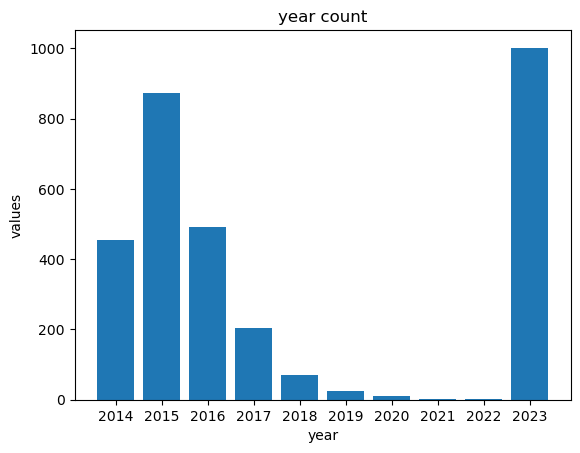

2131

In [301]:
#check for outliers by year
year_count=merged_df['year'].value_counts()
plt.bar(year_count.index, year_count)
plt.xlabel('year')
plt.ylabel('values')
plt.title('year count')
plt.xticks(year_count.index)
plt.show()
sum(merged_df.year<2023)

C:\Users\hadar\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


16

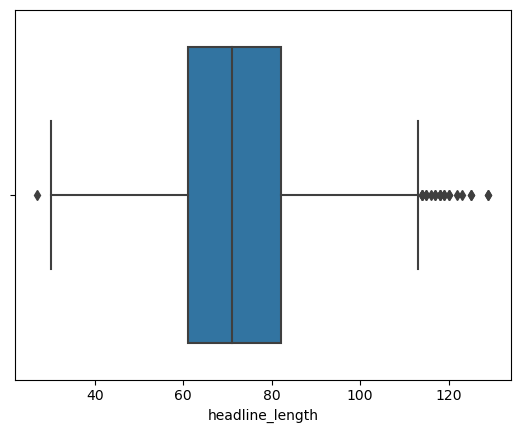

In [304]:
#check for outliers by text length
sns.boxplot(merged_df.headline_length)
sum(merged_df.headline_length>115) #consider to remove all articles with headlin length above 115 - no need

C:\Users\hadar\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='content_length'>

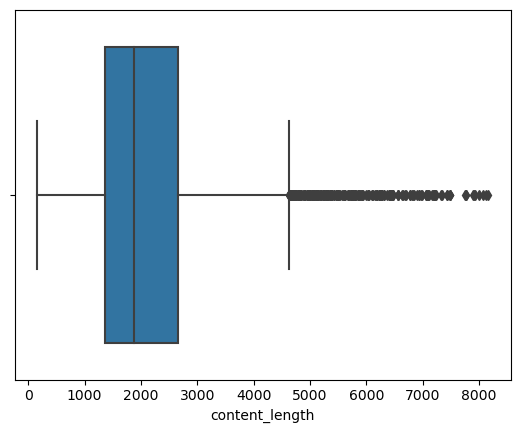

In [306]:
#check for outliers by text length
sns.boxplot(merged_df.content_length)

## Visualisation
We wanted to examine the length of the text in relation to whether the article is fake or not.</br>
Started with one dimentional visualisation, showing some of the categories:

In [60]:
merged_df=pd.read_csv('merged_df_after_dup.csv')

In [61]:
is_fake_values=merged_df['is_fake'].value_counts()
is_fake_values

1.0    2135
0.0     780
Name: is_fake, dtype: int64

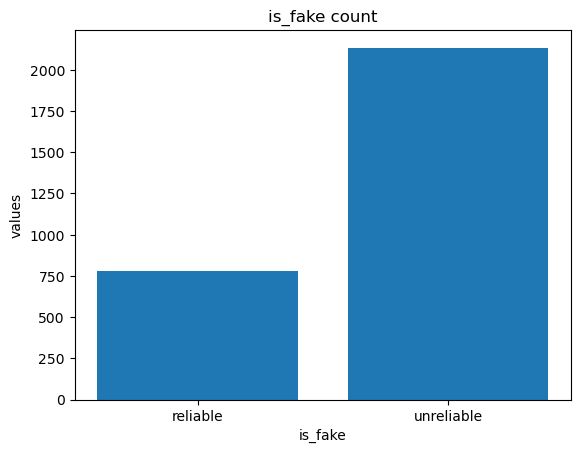

In [62]:
#Show how many reliable and unreliable data we've collected. Notice there are more articles that has no value and will be tested later
plt.bar(is_fake_values.index, is_fake_values)
plt.xlabel('is_fake')
plt.ylabel('values')
plt.title('is_fake count')
plt.xticks(is_fake_values.index,['unreliable','reliable'])
plt.show()

we can see that the reliable and unreliable data is not balanced, but hence we do not have big dataset we wanted to to use it all and examine the effect on the results.

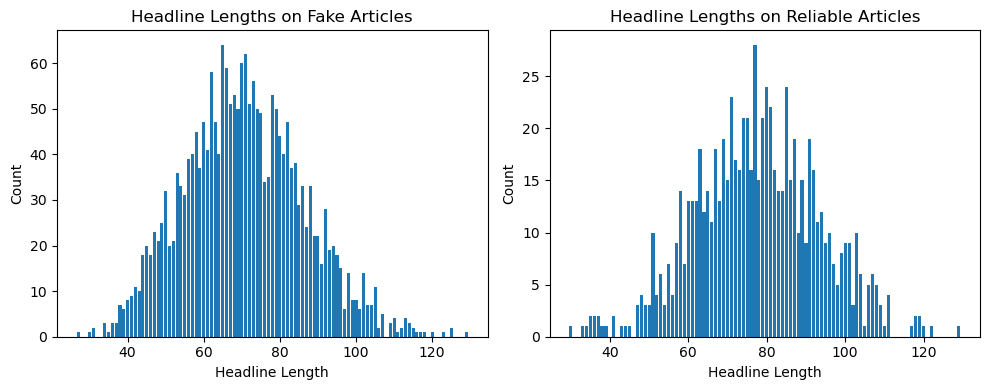

In [63]:
#----------
#Analyze the headline length
#----------
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

fake_df=merged_df[merged_df['is_fake']==1]
reliable_df=merged_df[merged_df['is_fake']==0]

axes[0].bar(fake_df['headline_length'].value_counts().index, fake_df['headline_length'].value_counts())
axes[0].set_xlabel('Headline Length')
axes[0].set_ylabel('Count')
axes[0].set_title('Headline Lengths on Fake Articles')

axes[1].bar(reliable_df['headline_length'].value_counts().index, reliable_df['headline_length'].value_counts())
axes[1].set_xlabel('Headline Length')
axes[1].set_ylabel('Count')
axes[1].set_title('Headline Lengths on Reliable Articles')

plt.tight_layout()
plt.show()

We see that the length of the headlines are pretty similar for all articles, so we assume that it won't affect the <b>'is_fake'</b> argument.

<b>Analyze the content length</b>

<AxesSubplot:xlabel='content_length', ylabel='Density'>

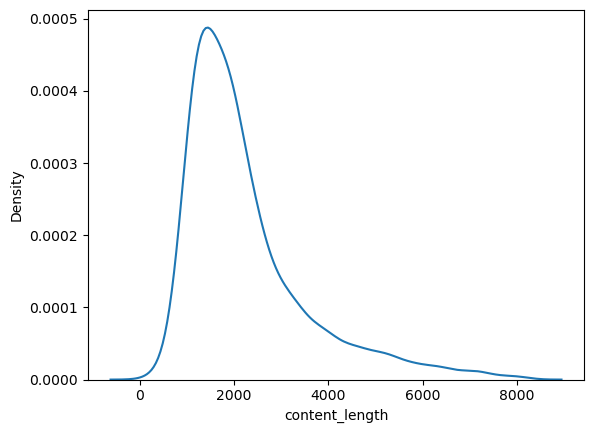

In [313]:
sns.kdeplot(merged_df.content_length)

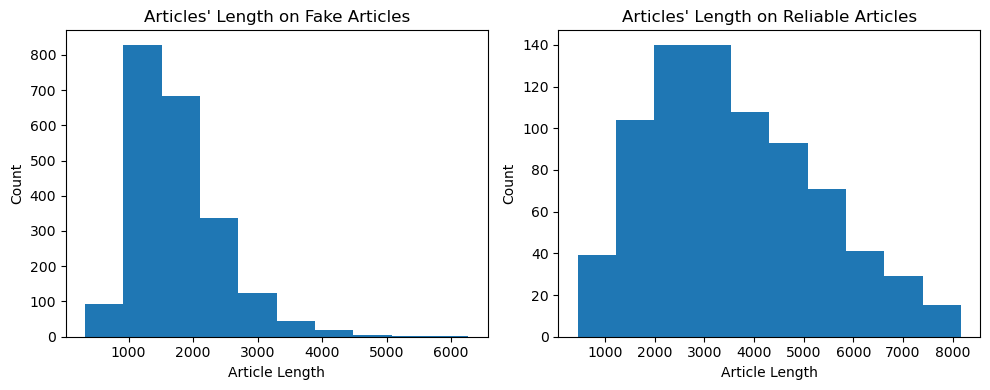

In [64]:
#----------
#Analyze the headline length
#----------
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

fake_df=merged_df[merged_df['is_fake']==1]
reliable_df=merged_df[merged_df['is_fake']==0]

axes[0].hist(fake_df['content_length'],bins=10)
axes[0].set_xlabel('Article Length')
axes[0].set_ylabel('Count')
axes[0].set_title("Articles' Length on Fake Articles")

axes[1].hist(reliable_df['content_length'],bins=10)
axes[1].set_xlabel('Article Length')
axes[1].set_ylabel('Count')
axes[1].set_title("Articles' Length on Reliable Articles")

plt.tight_layout()
plt.show()

We can see that fake articles tend to be slightly shorter than reliable artices.

### Text Analysis and Machine Learning
On this section we analyzed the content and used it to train our model.</br>
we preprocessed the text for getting more accurate results, and used <b>BOW</b> (Bag of Words) representation to train.

<b>Supervised Learning-</b></br>
We wanted to train the model according to classification we had for fake/reliable content.</br>
We test Naive Bayes, Decision Tree and Linear Regression models and compared the results for getting the best model.

In [65]:
#----------
#preprocess content column
#----------
#nltk.download('punkt')
#nltk.download('stopwords')
def preprocess_text(text):
    #text cleaning
    text=text.lower()
    text=''.join(c for c in text if c.isalnum() or c.isspace())

    tokens=word_tokenize(text)#tokenization
    stop_words=set(stopwords.words('english'))
    tokens=[token for token in tokens if token not in stop_words]

    processed_text=' '.join(tokens)
    return processed_text

In [66]:
txt_df=merged_df
txt_df['processed_content'] = merged_df['content'].apply(preprocess_text)

In [67]:
txt_df

,headline,headline_length,writers,genre,date,year,month,content,content_length,is_fake,processed_content
0,Knesset passes 2023-2024 state budget,37.0,JNS,Israel,2023-05-24,2023,5,Israel’s Knesset on Wednesday passed the state...,2253.0,NaN,israels knesset wednesday passed state budget ...
1,Will flights from Israel to Mecca spark Temple...,103.0,Adam Eliyahu Berkowitz,Israel,2023-05-23,2023,5,Prime Minister Netanyahu was in direct contact...,6400.0,NaN,prime minister netanyahu direct contact saudi ...
2,Rabbi Leo Dee weighs $1.3b. suit against Amanpour,49.0,JNS,Israel,2023-05-23,2023,5,Rabbi Leo Dee is considering suing CNN chief i...,3946.0,NaN,rabbi leo dee considering suing cnn chief inte...
3,Israeli Cabinet boosts funds for Kotel infrast...,53.0,JNS,Israel,2023-05-22,2023,5,The Israeli Cabinet on Sunday approved funding...,2850.0,NaN,israeli cabinet sunday approved funding upgrad...
4,Ben-Gvir visits Temple Mount: ‘We are the owne...,73.0,JNS,Israel,2023-05-21,2023,5,During a visit to the Temple Mount in Jerusale...,1667.0,NaN,visit temple mount jerusalem sunday israeli na...
...,...,...,...,...,...,...,...,...,...,...,...
3128,Parisians Must Live With Rats – Mayor,37.0,RT,News,2023-06-13,2023,6,Paris Mayor Anne Hidalgo plans to form a commi...,2474.0,1.0,paris mayor anne hidalgo plans form committee ...
3129,South Africa Mulls Moving BRICS Summit To Chin...,73.0,Zero Hedge,News,2023-06-13,2023,6,South African media is reporting that the coun...,4541.0,1.0,south african media reporting country mulling ...
3130,Three dead in Nottingham UK after van tries to...,62.0,LBC News,News,2023-06-13,2023,6,Three people have been killed in Nottingham an...,1402.0,1.0,three people killed nottingham man arrested ar...
3131,‘God is queer!’ – German Lutheran pastor slamm...,88.0,Remix News,News,2023-06-13,2023,6,A prominent Lutheran pastor in Germany told at...,4739.0,1.0,prominent lutheran pastor germany told attende...


### Visualize the top 20 common words
once in general and once in separation to fake and real news

C:\Users\hadar\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


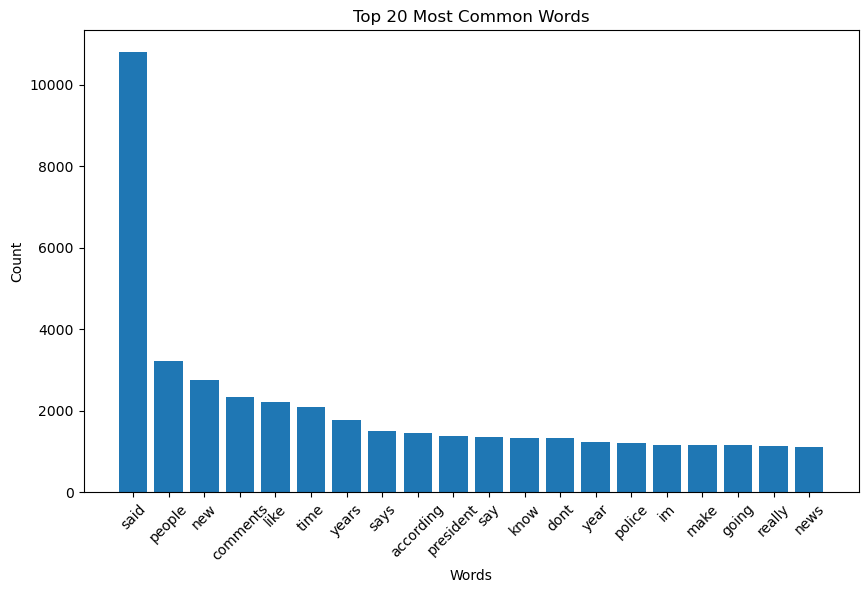

In [141]:
#----------
# Plot the top common words
# create vecorizer and show the most frequent words in all articles. Used Chat GPT for this section
#----------
vectorizer=CountVectorizer(stop_words="english")
X=vectorizer.fit_transform(txt_df['processed_content']) #Fit and transform the preprocessed text into a document-term matrix
word_counts=X.sum(axis=0) #Sum the word occurrences across all documents
feature_names=vectorizer.get_feature_names() #Get the feature names (words)
word_counts_df=pd.DataFrame({'Word': feature_names, 'Count': word_counts.flat})
word_counts_df=word_counts_df.sort_values('Count', ascending=False)#Sort the words based on their occurrence
top_words_df=word_counts_df.head(20)#Select the top 20 words with the highest occurrence count

# Plot the most common words
plt.figure(figsize=(10, 6))
plt.bar(top_words_df['Word'], top_words_df['Count'])
plt.xlabel('Words')
plt.ylabel('Count')
plt.title(f'Top 20 Most Common Words')
plt.xticks(rotation = 45)
plt.show()

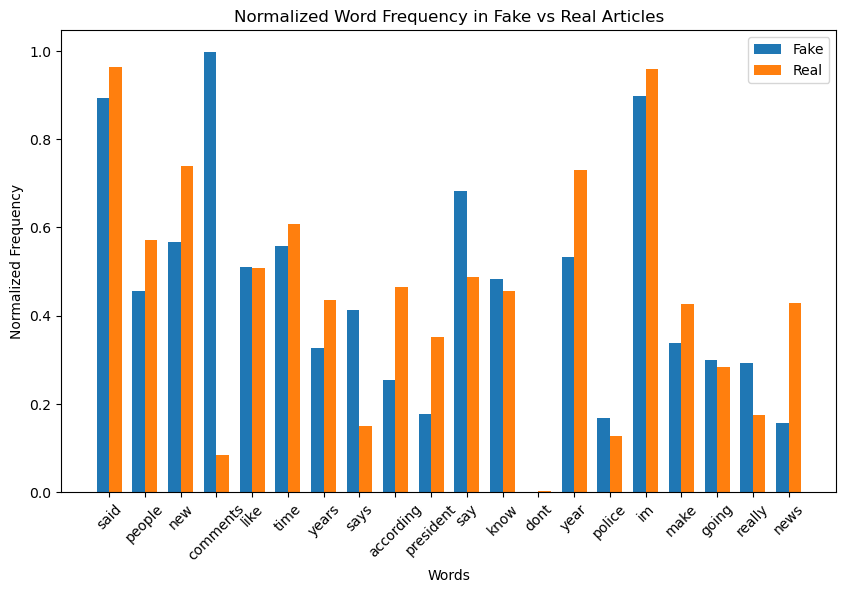

In [69]:
#----------
# get the normalaized appearance of every common word by division to real and fake news
#----------
top_common_words = list(top_words_df['Word'])

fake_articles=txt_df[txt_df['is_fake']==1]
real_articles=txt_df[txt_df['is_fake']==0]
fake_word_freq={}
real_word_freq={}

total_fake_articles=len(fake_articles)
total_real_articles=len(real_articles)

#calculate word frequencies
for word in top_common_words:
    fake_word_freq[word]=(fake_articles['content'].str.contains(word,case=False).sum())/total_fake_articles
    real_word_freq[word]=(real_articles['content'].str.contains(word,case=False).sum())/total_real_articles

fake_word_freq_list = [fake_word_freq[word] for word in top_common_words]
real_word_freq_list = [real_word_freq[word] for word in top_common_words]

#set the positions of the bars on the x-axis (with chat GPT)
ind = np.arange(len(top_common_words))
width = 0.35

fig, ax=plt.subplots(figsize=(10, 6))
fake_bars=ax.bar(ind-width/2, fake_word_freq_list, width, label='Fake')
real_bars=ax.bar(ind+width/2, real_word_freq_list, width, label='Real')
ax.set_xlabel('Words')
ax.set_ylabel('Normalized Frequency')
ax.set_title('Normalized Word Frequency in Fake vs Real Articles')
ax.set_xticks(ind)
ax.set_xticklabels(top_common_words, rotation=45)
ax.legend()

plt.show()

### most common word on fake and real news separately

C:\Users\hadar\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


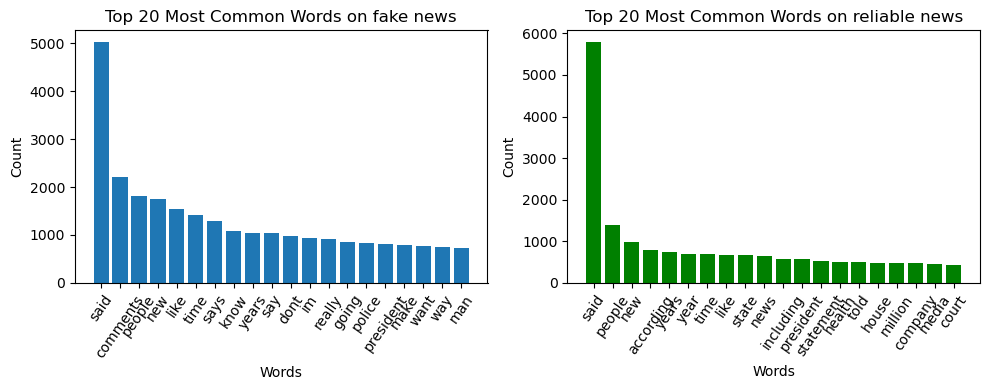

In [91]:
# Combine the processed content of fake and real articles
X=vectorizer.fit_transform(txt_df['processed_content'])

# Split the transformed data into fake and real parts
X_fake = X[:len(fake_articles)]
X_real = X[len(fake_articles):]

fake_word_counts = X_fake.sum(axis=0) 
real_word_counts = X_real.sum(axis=0) 

feature_names=vectorizer.get_feature_names() #Get the feature names (words)

fake_word_counts_df=pd.DataFrame({'Word': feature_names, 'Count': fake_word_counts.flat})
fake_word_counts_df=fake_word_counts_df.sort_values('Count', ascending=False)#Sort the words based on their occurrence
fake_top_words_df=fake_word_counts_df.head(20)#Select the top 20 words with the highest occurrence count

real_word_counts_df=pd.DataFrame({'Word': feature_names, 'Count': real_word_counts.flat})
real_word_counts_df=real_word_counts_df.sort_values('Count', ascending=False)#Sort the words based on their occurrence
real_top_words_df=real_word_counts_df.head(20)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

axes[0].bar(fake_top_words_df['Word'], fake_top_words_df['Count'])
axes[0].set_xlabel('Words')
axes[0].set_ylabel('Count')
axes[0].set_title(f'Top 20 Most Common Words on fake news')
axes[0].tick_params(axis='x', rotation=55)

axes[1].bar(real_top_words_df['Word'], real_top_words_df['Count'],color='green')
axes[1].set_xlabel('Words')
axes[1].set_ylabel('Count')
axes[1].set_title(f'Top 20 Most Common Words on reliable news')
axes[1].tick_params(axis='x', rotation=55)

plt.tight_layout()
plt.show()

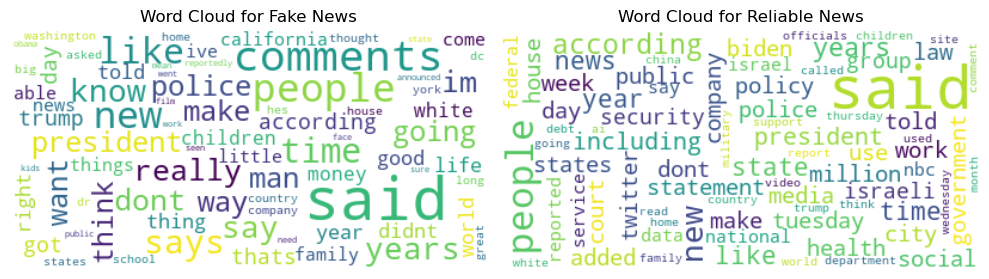

In [97]:
fake_freq_vec=X_fake.sum(axis=0)
real_freq_vec=X_real.sum(axis=0)

fake_freq_dist=dict(zip(feature_names, fake_freq_vec.flat))
real_freq_dist=dict(zip(feature_names, real_freq_vec.flat))

fake_freq_dist=dict(sorted(fake_freq_dist.items(), key=lambda item: item[1], reverse=True))
real_freq_dist=dict(sorted(real_freq_dist.items(), key=lambda item: item[1], reverse=True))

fake_wordcloud=WordCloud(max_font_size=50, max_words=75, background_color="white").generate_from_frequencies(fake_freq_dist)
real_wordcloud=WordCloud(max_font_size=50, max_words=75, background_color="white").generate_from_frequencies(real_freq_dist)

fig, axes=plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

axes[0].imshow(fake_wordcloud, interpolation="bilinear")
axes[0].set_title("Word Cloud for Fake News")
axes[0].axis("off")

axes[1].imshow(real_wordcloud, interpolation="bilinear")
axes[1].set_title("Word Cloud for Reliable News")
axes[1].axis("off")

plt.tight_layout()
plt.show()


# Machine Learning
We will use supervised learning for classification. The label column will be is_fake.
for the machine learning we will drop the rows that does not have is_fake value (we will predict them in the end)

In [101]:
train_df=txt_df[txt_df['is_fake'].notna()]

In [143]:
X_train, X_test, y_train, y_test = train_test_split(train_df.processed_content,train_df.is_fake,test_size=0.2)
X_train_cv=vectorizer.fit_transform(X_train.values)

### create BOW (Bag of Words) representation using CountVectorizer
used a Youtube tutorial - https://www.youtube.com/watch?v=Yt1Sw6yWjlw&ab_channel=codebasics

### Naive Bayes

In [146]:
model = MultinomialNB()
model.fit(X_train_cv, y_train)

y_pred_train=model.predict(X_train_cv)
accuracy_train=accuracy_score(y_train, y_pred_train)
print("Accuracy on training data:", accuracy_train)

X_test_cv=vectorizer.transform(X_test)
y_pred=model.predict(X_test_cv)
accuracy=accuracy_score(y_test, y_pred)
print("Accuracy on test data:", accuracy)

f1_score_nb = f1_score(y_test, y_pred)
print("f1-score:", f1_score_nb)

Accuracy on training data: 0.9922813036020584
Accuracy on test data: 0.9571183533447685
f1-score: 0.9708963911525029


### Decision Tree

In [133]:
decisionTree = tree.DecisionTreeClassifier() #(max_depth=params['max_depth'], min_samples_split=params['min_samples_split'])
decisionTree = decisionTree.fit(X_train_cv, y_train)
y_pred_train = decisionTree.predict(X_train_cv)
print('Accuracy on training data = ', 
      metrics.accuracy_score(y_true = y_train, y_pred = y_pred_train))

y_pred = decisionTree.predict(X_test_cv)
print('Accuracy on test data = ', 
      metrics.accuracy_score(y_true = y_test, y_pred = y_pred))

f1_score_decision_tree = f1_score(y_test, y_pred)
print("f1-score:", f1_score_decision_tree)

Accuracy on training data =  1.0
Accuracy on test data =  0.9828473413379074
f1-score: 0.9882629107981221


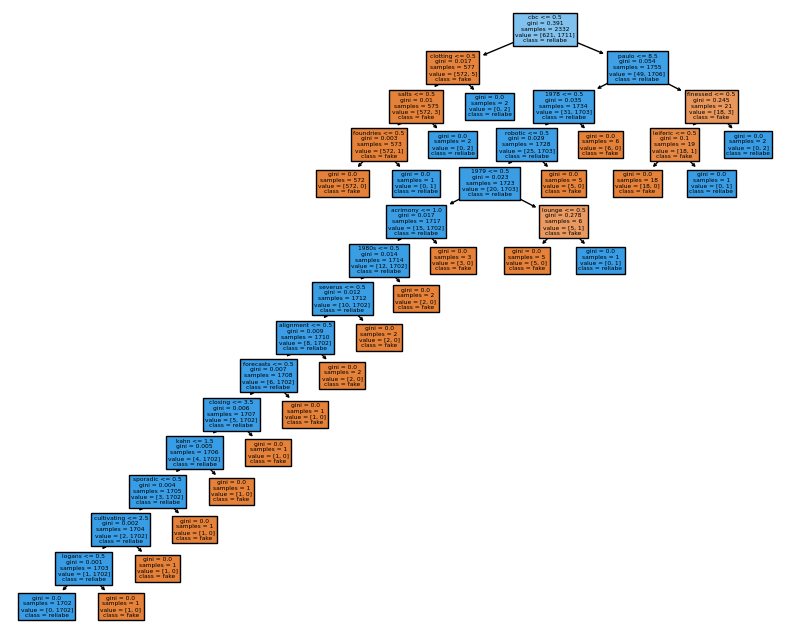

In [134]:
plt.figure(figsize=(10, 8))
tree.plot_tree(decisionTree, feature_names=feature_names, class_names=['fake','reliabe'], filled=True)
plt.show()

### Linear Regression

In [151]:
lrm=linear_model.LinearRegression().fit(X_train_cv, y_train)
y_pred_train = lrm.predict(X_train_cv)
train_accuracy = lrm.score(X_train_cv, y_train)
print('Accuracy on training data =', train_accuracy)
y_pred = lrm.predict(X_test_cv)
test_accuracy = lrm.score(X_test_cv, y_test)
print('Accuracy on test data =', test_accuracy)

r2 = r2_score(y_test, y_pred)
print("R-squared:", r2)

Accuracy on training data = 0.9999999992038767
Accuracy on test data = 0.7203384881022445
R-squared: 0.7203384881022445


## Using our model to predict!
After examine those three model we are ready to predict the answer for our articles.
We will use the decision tree model that had the best score of all.

In [129]:
predict_df=txt_df[txt_df['is_fake'].isna()]

In [150]:
X=predict_df.processed_content
X_cv=vectorizer.transform(predict_df.processed_content.values)
y_pred=decisionTree.predict(X_cv)
predict_df['is_fake']=y_pred
predict_df

C:\Users\hadar\AppData\Local\Temp\ipykernel_6320\1818227369.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predict_df['is_fake']=y_pred


,headline,headline_length,writers,genre,date,year,month,content,content_length,is_fake,processed_content
0,Knesset passes 2023-2024 state budget,37.0,JNS,Israel,2023-05-24,2023,5,Israel’s Knesset on Wednesday passed the state...,2253.0,0.0,israels knesset wednesday passed state budget ...
1,Will flights from Israel to Mecca spark Temple...,103.0,Adam Eliyahu Berkowitz,Israel,2023-05-23,2023,5,Prime Minister Netanyahu was in direct contact...,6400.0,0.0,prime minister netanyahu direct contact saudi ...
2,Rabbi Leo Dee weighs $1.3b. suit against Amanpour,49.0,JNS,Israel,2023-05-23,2023,5,Rabbi Leo Dee is considering suing CNN chief i...,3946.0,0.0,rabbi leo dee considering suing cnn chief inte...
3,Israeli Cabinet boosts funds for Kotel infrast...,53.0,JNS,Israel,2023-05-22,2023,5,The Israeli Cabinet on Sunday approved funding...,2850.0,0.0,israeli cabinet sunday approved funding upgrad...
4,Ben-Gvir visits Temple Mount: ‘We are the owne...,73.0,JNS,Israel,2023-05-21,2023,5,During a visit to the Temple Mount in Jerusale...,1667.0,0.0,visit temple mount jerusalem sunday israeli na...
...,...,...,...,...,...,...,...,...,...,...,...
3122,Gaza family with 5 disabled siblings homeless ...,69.0,Unknown,Middle East,2023-05-16,2023,5,When an Israeli missile struck the residential...,3111.0,0.0,israeli missile struck residential block nabha...
3123,World Bank: Jordan could face 'shocks' due to ...,64.0,Unknown,Middle East,2023-05-16,2023,5,The World Bank warned of shocks affecting Jord...,1346.0,0.0,world bank warned shocks affecting jordans eco...
3124,GCC military official discusses military issue...,65.0,Unknown,Middle East,2023-05-16,2023,5,A Gulf Cooperation Council (GCC) senior milita...,1338.0,0.0,gulf cooperation council gcc senior military o...
3125,Nakba Day: 75 years since Palestine's 'catastr...,74.0,Unknown,Middle East,2023-05-16,2023,5,READ: The symbolic Nakba commemoration at the ...,183.0,0.0,read symbolic nakba commemoration un exposed i...
